In [1]:
import csv
import gzip
import time
import os
import pandas as pd
import re
from numpy import where as npwhere
from functools import reduce

def mapMethytilatedCitosine(metfile,intersection_file_path,output_file_path):
    chrs_data = {}
    with gzip.open(metfile, 'rt') as f:
        for line in f:
            chr_index = line.split('\t')[0]
            coordinate_index = int(line.split('\t')[1])
            try:
                chrs_data[chr_index][coordinate_index] = line[:-5]
            except:
                chrs_data[chr_index] = {coordinate_index:line[:-5]}

    with open(intersection_file_path) as f:
        reader = csv.reader(f, delimiter='\t')
        data = list(reader)

    with open(output_file_path, 'w') as whateverBox:
        for each_box in data:
            box_areas = {}
            box_start = int(each_box[1])
            box_end = int(each_box[2])
            chr_location = each_box[0]
            sequence_identifier = each_box[3]
            # tenemos que aplicar rango desde una posicion inicial porque es un archivo 0 based, si fuese 1 based el rango estaría mal y tendria que restarle
            # uno al archivo al box start
            box_areas['box'] = list(range(box_start, box_end))

            for boxarea in box_areas:
                for coordinate in box_areas[boxarea]:
                    matchline = chrs_data[chr_location].get(coordinate, False)
                    if matchline:
                        whateverBox.write('{}\t{}\t{}\n'.format(matchline, sequence_identifier, boxarea))
                        

def loadFileRemoveMtsAndLowMetReport(replicate,cgcontext):
        bxdf = pd.read_csv(
            replicate,
            sep='\t', 
            names=['chr', 'position', 'strand', 'mets', 'nomets', 'context', 'boxID', 'side'],
            usecols=['chr', 'position','strand', 'boxID','context','mets', 'nomets', ]
                )
        
        bxdf.drop(bxdf[(bxdf.chr == 'Mt') | (bxdf.chr == 'Pt')].index, inplace=True)
        if cgcontext == 'CG':
            bxdf.drop(bxdf[(bxdf.context != 'CG')].index, inplace=True)
        if cgcontext == 'nonCG':
            bxdf.drop(bxdf[(bxdf.context == 'CG')].index, inplace=True)
        
        bxdf = bxdf[bxdf['mets'] + bxdf['nomets'] > 4]
        
        return bxdf

def calculateValueAsPercentageOfMetCs(replicatedf,replicanamedf):
    replicatedf[replicanamedf] = replicatedf['mets'] / (replicatedf['nomets'] + replicatedf['mets'])
    replicatedf = replicatedf.drop(columns=['mets','nomets'])
    return replicatedf
def calculateValueAsWheigtedPercentageOfMetCs(replicatedf=None,replicanamedf=None):
    # replicatedf = replicatedf.drop(columns=['chr','context'])
    # replicatedf = replicatedf.groupby('boxID', as_index=False).sum()
    replicatedf[replicanamedf] = replicatedf['mets'] / (replicatedf['nomets'] + replicatedf['mets'])
    replicatedf = replicatedf.drop(columns=['mets','nomets'])
    return replicatedf
def calculateValueAsCualitative(replicatedf,replicanamedf):
    """only zero or one, meaning one that there is methylation"""
    replicatedf[replicanamedf] = npwhere(replicatedf['mets']>replicatedf['nomets'], 1, 0)
    replicatedf = replicatedf.drop(columns=['mets','nomets'])
    return replicatedf

In [ ]:
import shutil
def movetofolderallthefiles(origin, destinationfolder):
    shutil.copy2(origin, destinationfolder)

In [2]:
working_folder = '/home/joaquin/projects/methylation/data/bisulfite_quick_and_dirty_rep1_rep2'
intersection_file = '/home/joaquin/projects/methylation/data/commonData/arabidopsisThaliana/intersect/Peaks_centered_56bp.bed'
basedmrfolder = '/home/joaquin/projects/methylation/methylation_jose/met_site'
experimentsClasification = {}
for root, dirs, files in os.walk(working_folder):

    for file in files:
        if file.endswith('CX_report.txt.gz'):
            replicate, hour, condition =root.strip().split('/')[-3:]
            experimentName = hour+condition
            experimentsClasification.setdefault(experimentName, [])
            targetMetFilename = root+'/'+file
            finalnamedestination = basedmrfolder+'/'+experimentName+replicate+'_CX_report.txt.gz'
            outputfile = targetMetFilename[:-3] + 'Peaks_centered_56bp.tsv'
            experimentsClasification[experimentName].append(outputfile)

            # mapMethytilatedCitosine(targetMetFilename,intersection_file,outputfile)

            

In [3]:
peaksfile = '/home/joaquin/projects/methylation/data/commonData/arabidopsisThaliana/intersect/Peaks_centered_56bp.bed'

peaks = pd.read_csv(peaksfile, sep='\t', names=['chrm','start','end','boxID'])

In [4]:
peaksfile = '/home/joaquin/projects/methylation/data/commonData/arabidopsisThaliana/intersect/peaks_wcluster_clean.txt'

clusters = pd.read_csv(peaksfile, sep='\t', names=['chrm','start','end','end2','boxID','cluster'], usecols=['boxID','cluster'])

In [108]:
clusters

,boxID,cluster
0,P00001,C10
1,P00002,C02
2,P00003,C11
3,P00005,C13
4,P00006,C10
...,...,...
58581,P59746,C03
58582,P59747,C03
58583,P59748,C03
58584,P59749,C07


In [5]:
list_ranges = []
range_num = list(range(1,57,1))
for boxid, start, end in zip(peaks['boxID'],peaks['start'],peaks['end']):
    range_digits = list(range(start,end,1))
    for val_pos, val_nopos in zip(range_digits,range_num):
        list_ranges.append((boxid,val_pos, val_nopos))


In [6]:
index_dataframe = pd.DataFrame(list_ranges, columns=['boxID', 'position','jmindex'])

In [7]:
index_dataframe

,boxID,position,jmindex
0,P00001,1513,1
1,P00001,1514,2
2,P00001,1515,3
3,P00001,1516,4
4,P00001,1517,5
...,...,...,...
3345995,P59750,26974876,52
3345996,P59750,26974877,53
3345997,P59750,26974878,54
3345998,P59750,26974879,55


In [19]:

toplot_mean = []
peaks = pd.read_csv(peaksfile, sep='\t', names=['chrm','start','end','boxID'])
for metcontext in ['nonCG']:  
    allthedata = []
    cgdataframe = []
    noncgdataframes = []
    finaldf = None
    for experimentCondition in experimentsClasification:
        listOfDfReplicatesPercentageOfMetCs = []
        listOfDfReplicatesCualitative = []
        listOfNamesReplicates = []
        df_merged = None
        for replicatePath in experimentsClasification[experimentCondition]:
            replicateDf = None
            replicaname =  experimentCondition+replicatePath.split('/')[-4]
            replicateDf = loadFileRemoveMtsAndLowMetReport(replicatePath, metcontext)
            replicateDfPercentageOfMetCs = calculateValueAsPercentageOfMetCs(replicateDf,replicaname)

            listOfNamesReplicates.append(replicaname)
            listOfDfReplicatesPercentageOfMetCs.append(replicateDfPercentageOfMetCs)

        df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['chr', 'position','strand', 'boxID','context',],
                                                    how='outer'), listOfDfReplicatesPercentageOfMetCs)


        df_merged[experimentCondition+'_'+metcontext] = df_merged[listOfNamesReplicates].mean(axis=1)

        df_merged = df_merged.drop(columns=listOfNamesReplicates)
        toplot_mean.append(df_merged.merge(index_dataframe, on=['boxID','position']),)
        # toplot_mean.append(df_merged[['jmindex',experimentCondition+'_'+metcontext]].groupby('jmindex').mean())
        
#         allthedata.append(df_merged)
#     finaldf = reduce(lambda  left,right: pd.merge(left,right,on=['boxID'],
#                                                     how='outer'), allthedata)
#     finaldf = peaks.merge(finaldf, on='boxID', how='outer')
#     finaldf = finaldf[['chrm','start','end','boxID','1Mock','1JA','1ACC','6Mock','6JA','6ACC','24Mock','24JA','24ACC']]



#     finaldf.to_csv(f'/home/joaquin/projects/methylation/data/bisulfite_quick_and_dirty_rep1_rep2/{metcontext}_BSMet.tsv',sep='\t', index=False)
    
    
#     finaldf = finaldf.dropna()

In [20]:
finaldf_means = reduce(lambda  left,right: pd.merge(left,right,on=['chr', 'position','strand', 'boxID','context','jmindex'],
                                                    how='outer'), toplot_mean)

In [21]:
finaldf_means = finaldf_means.merge(clusters, on='boxID')

In [22]:
finaldf_means_tosave = finaldf_means[['chr', 'position','strand', 'boxID','context','jmindex','cluster','1Mock_nonCG','1JA_nonCG','1ACC_nonCG','6Mock_nonCG','6JA_nonCG','6ACC_nonCG','24Mock_nonCG','24JA_nonCG','24ACC_nonCG']]

In [23]:
folder_path_result = '/home/joaquin/projects/methylation/data/bisulfite_quick_and_dirty_rep1_rep2/noncg_analisys_individual'

In [24]:
finaldf_means_tosave.to_csv(f'{folder_path_result}/cluster_clean_nonCG_mean.tsv',sep='\t')

C01
C02
C03
C04
C05
C06
C07
C08
C09
C10
C11
C12
C13
C14
C15


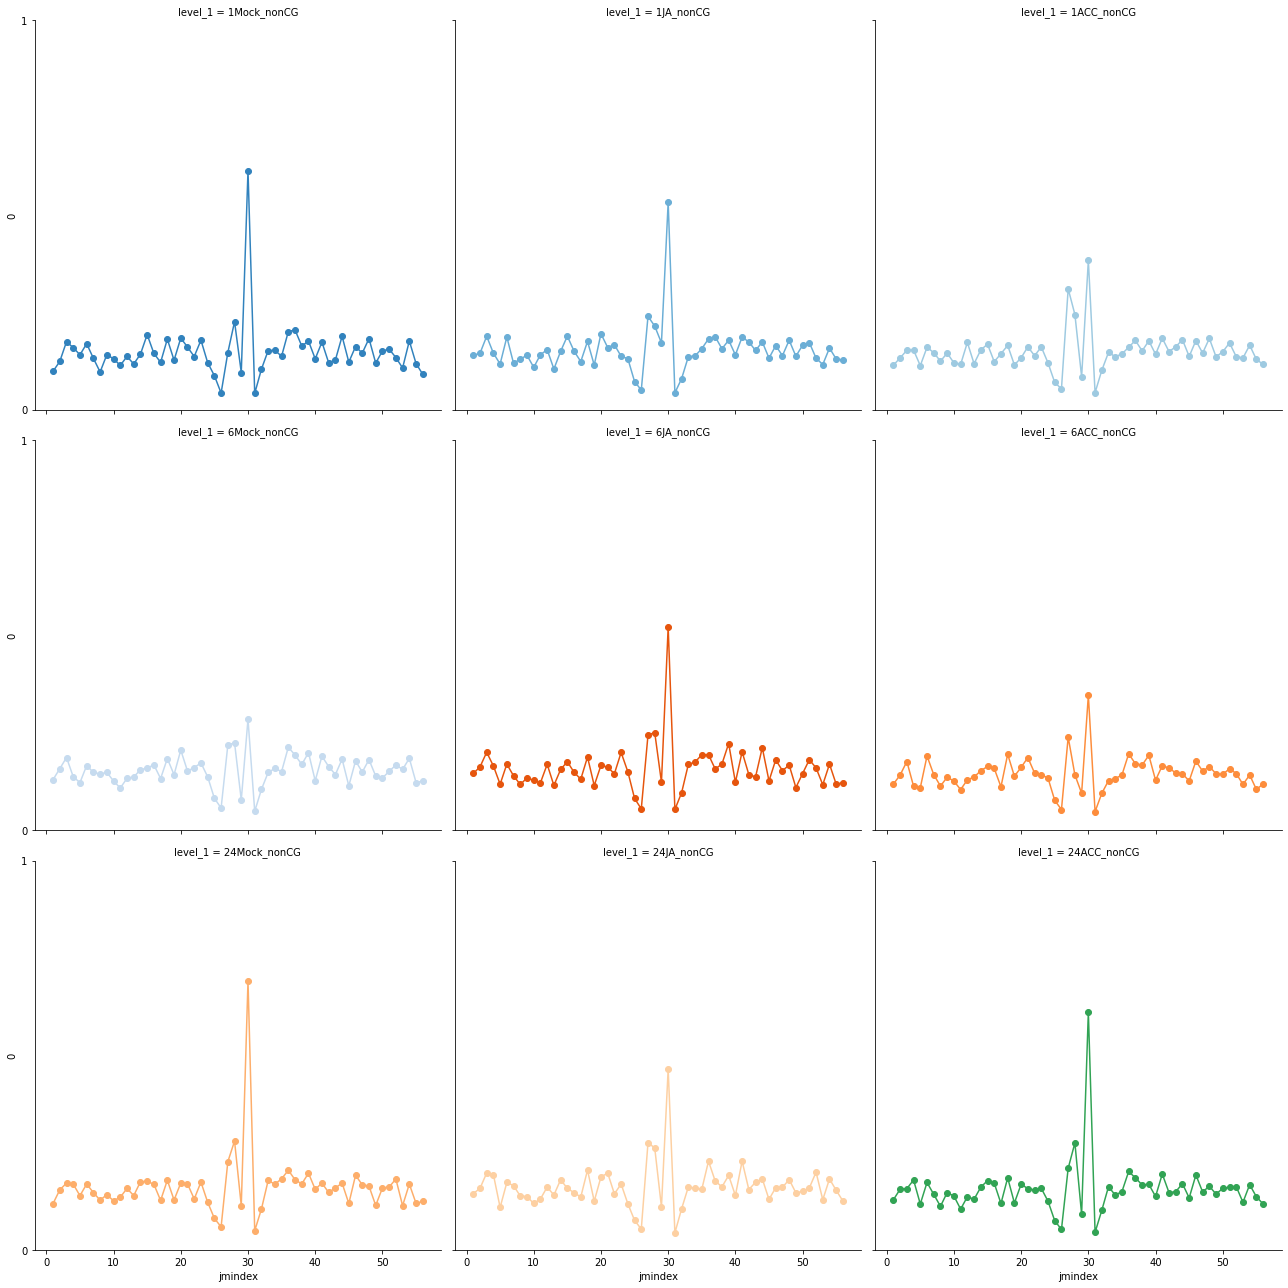

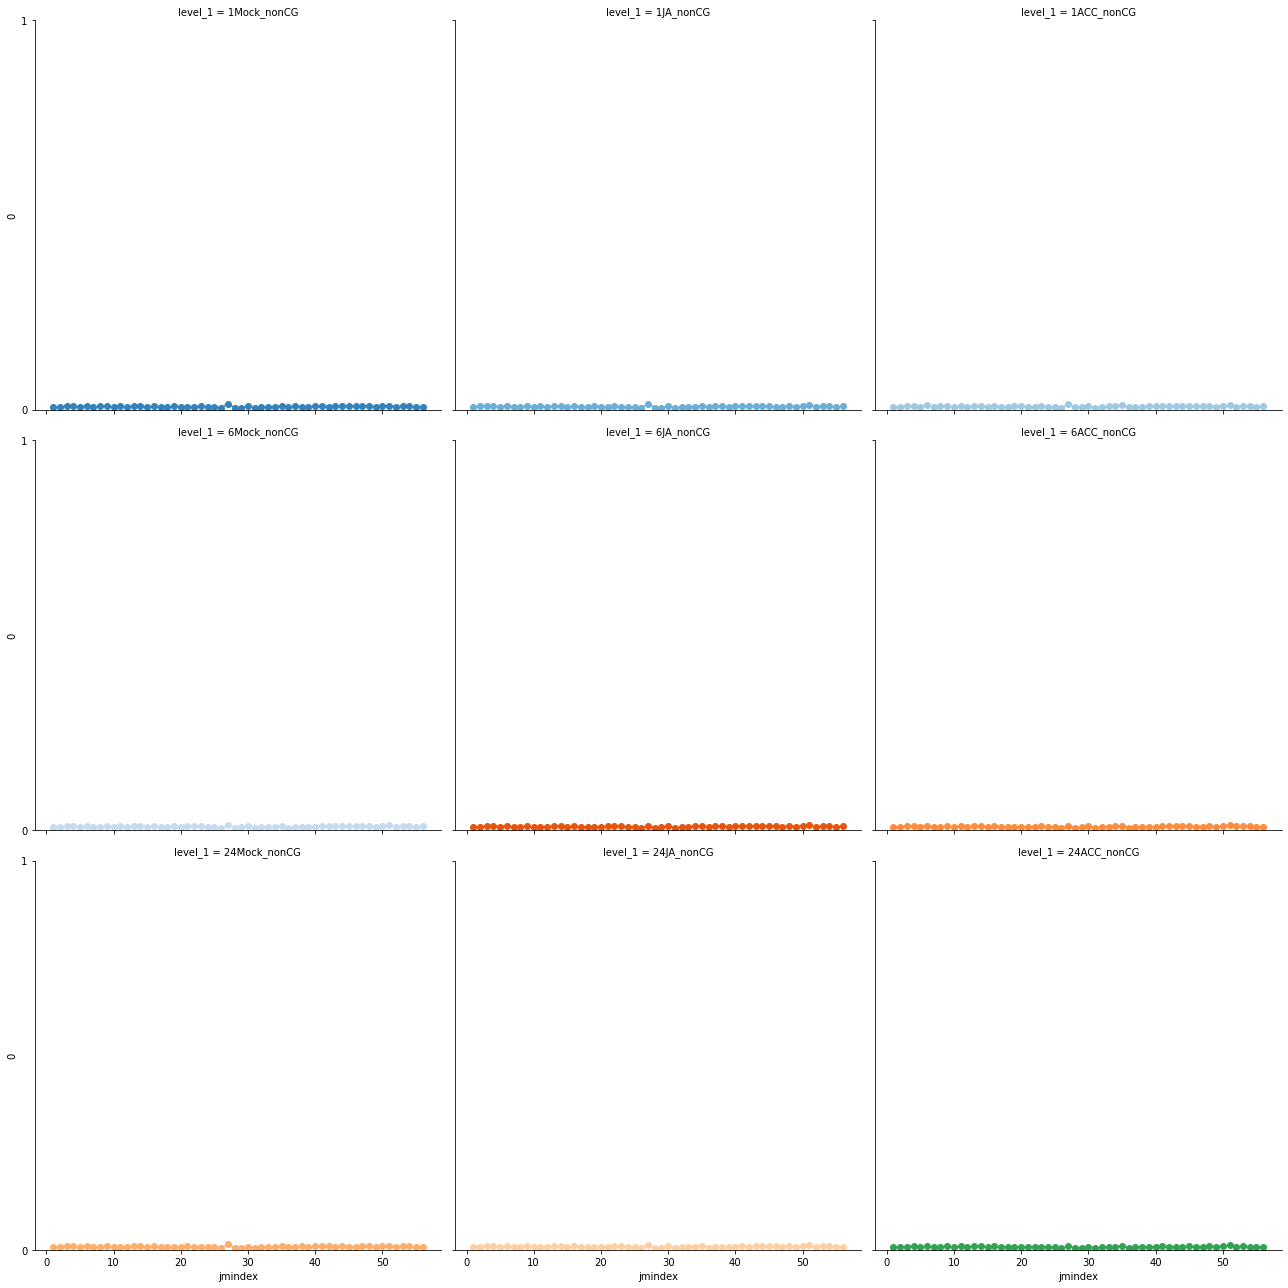

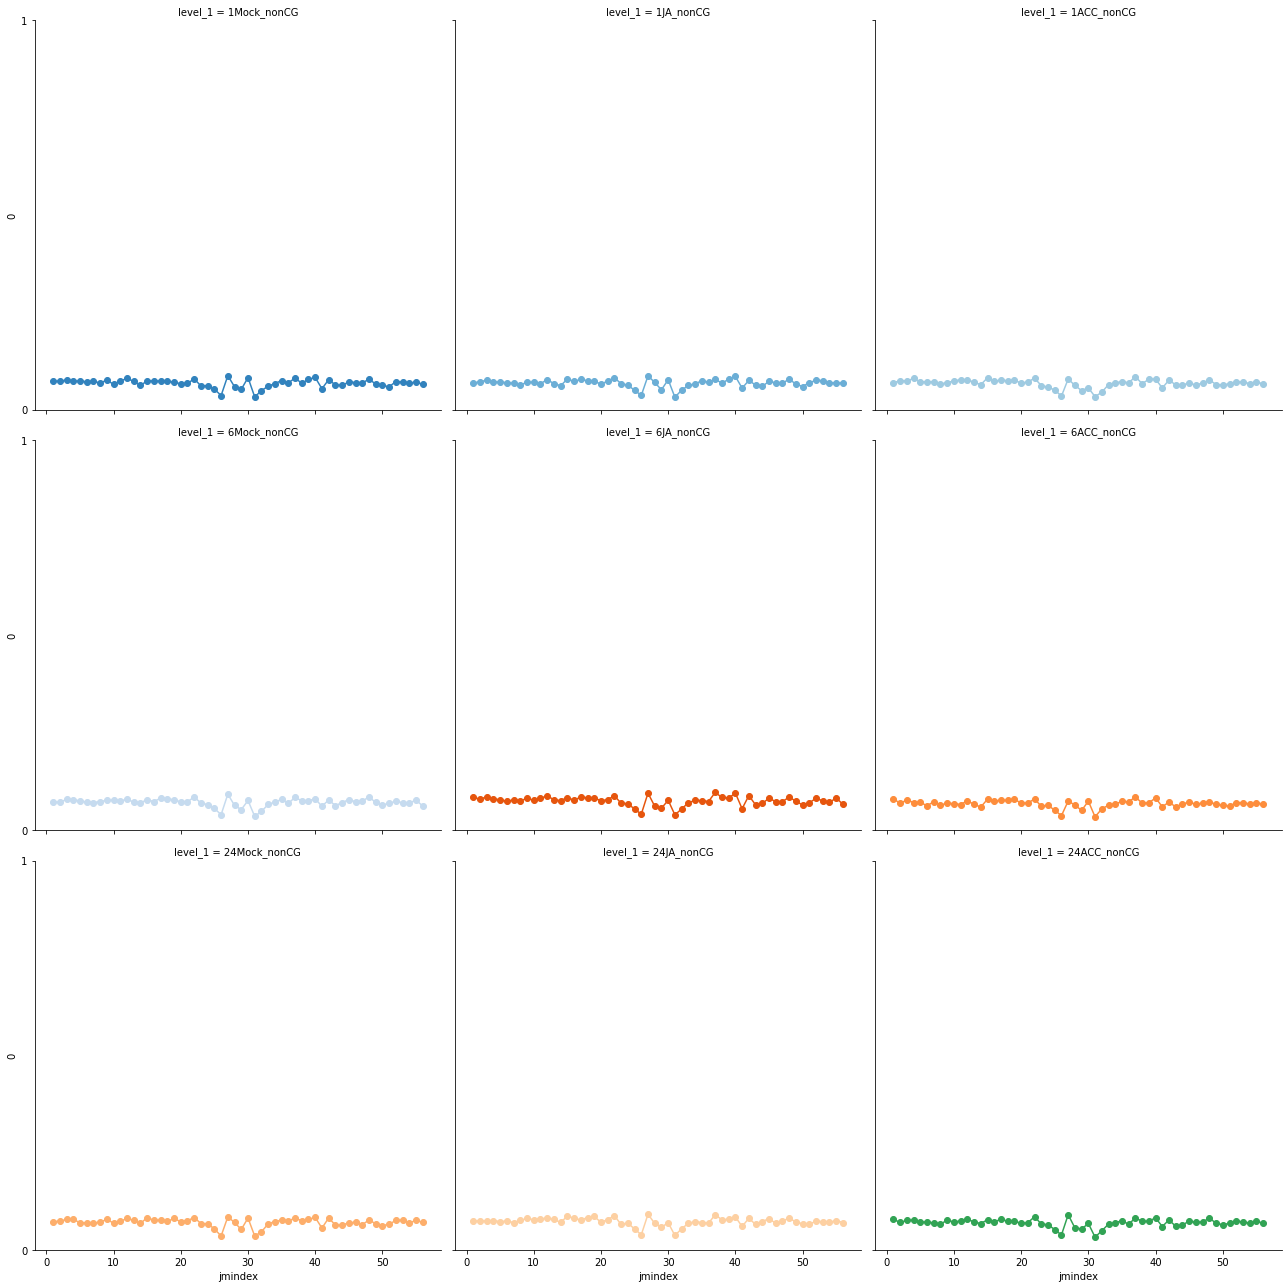

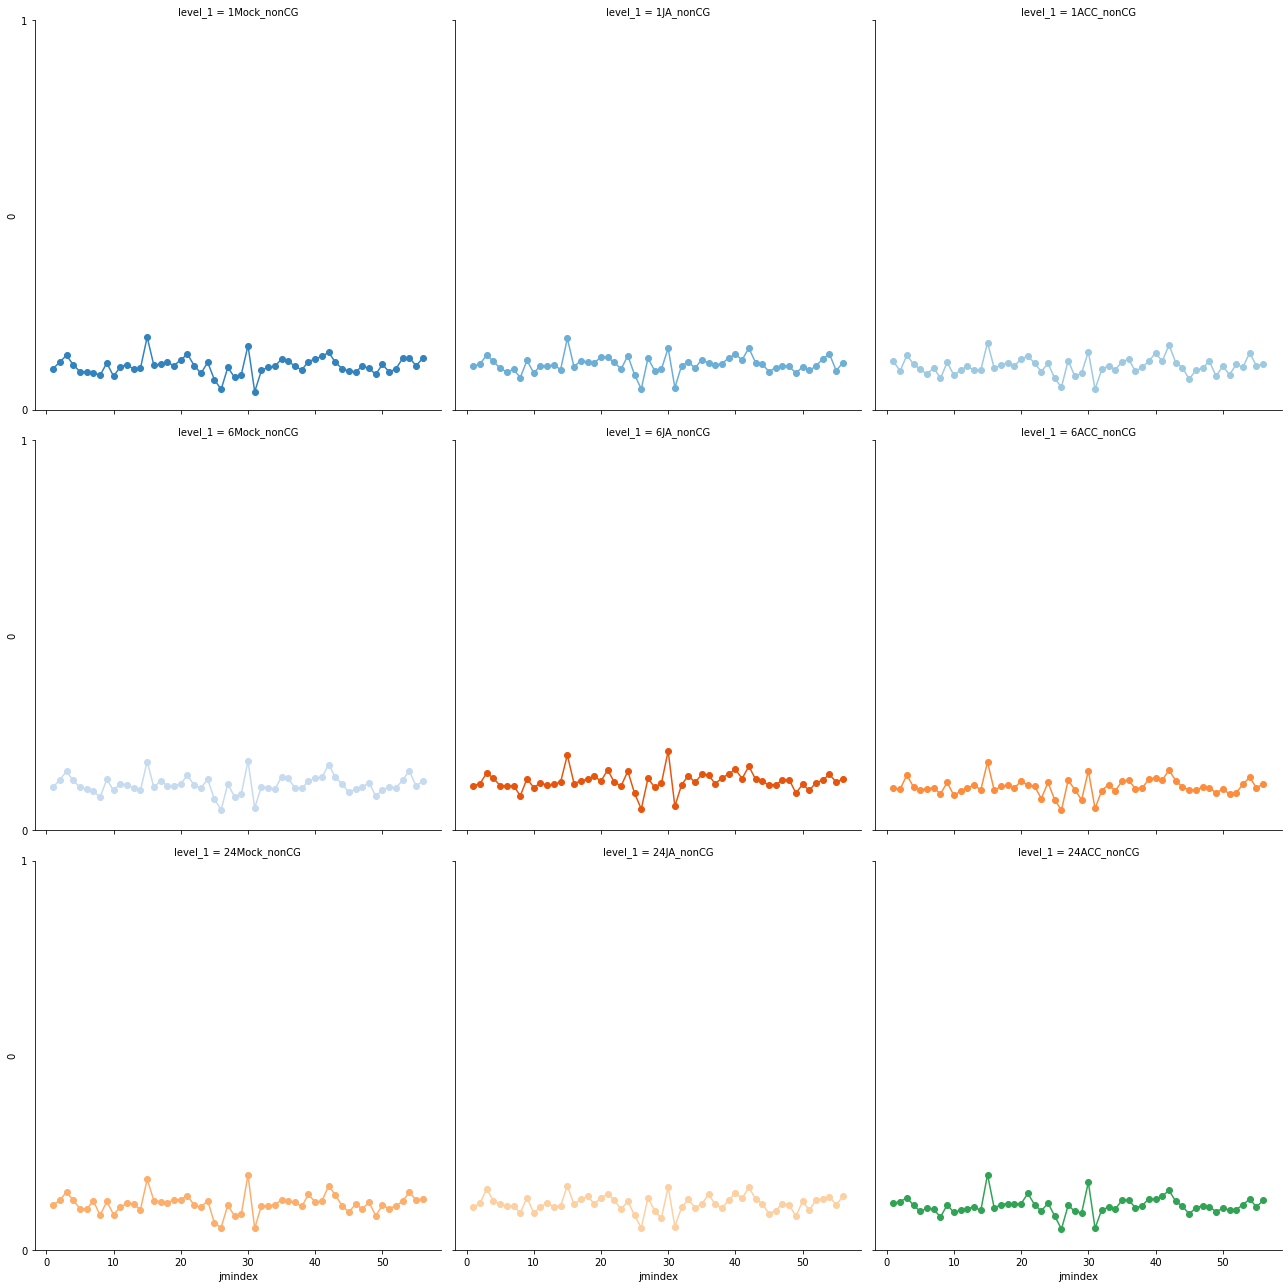

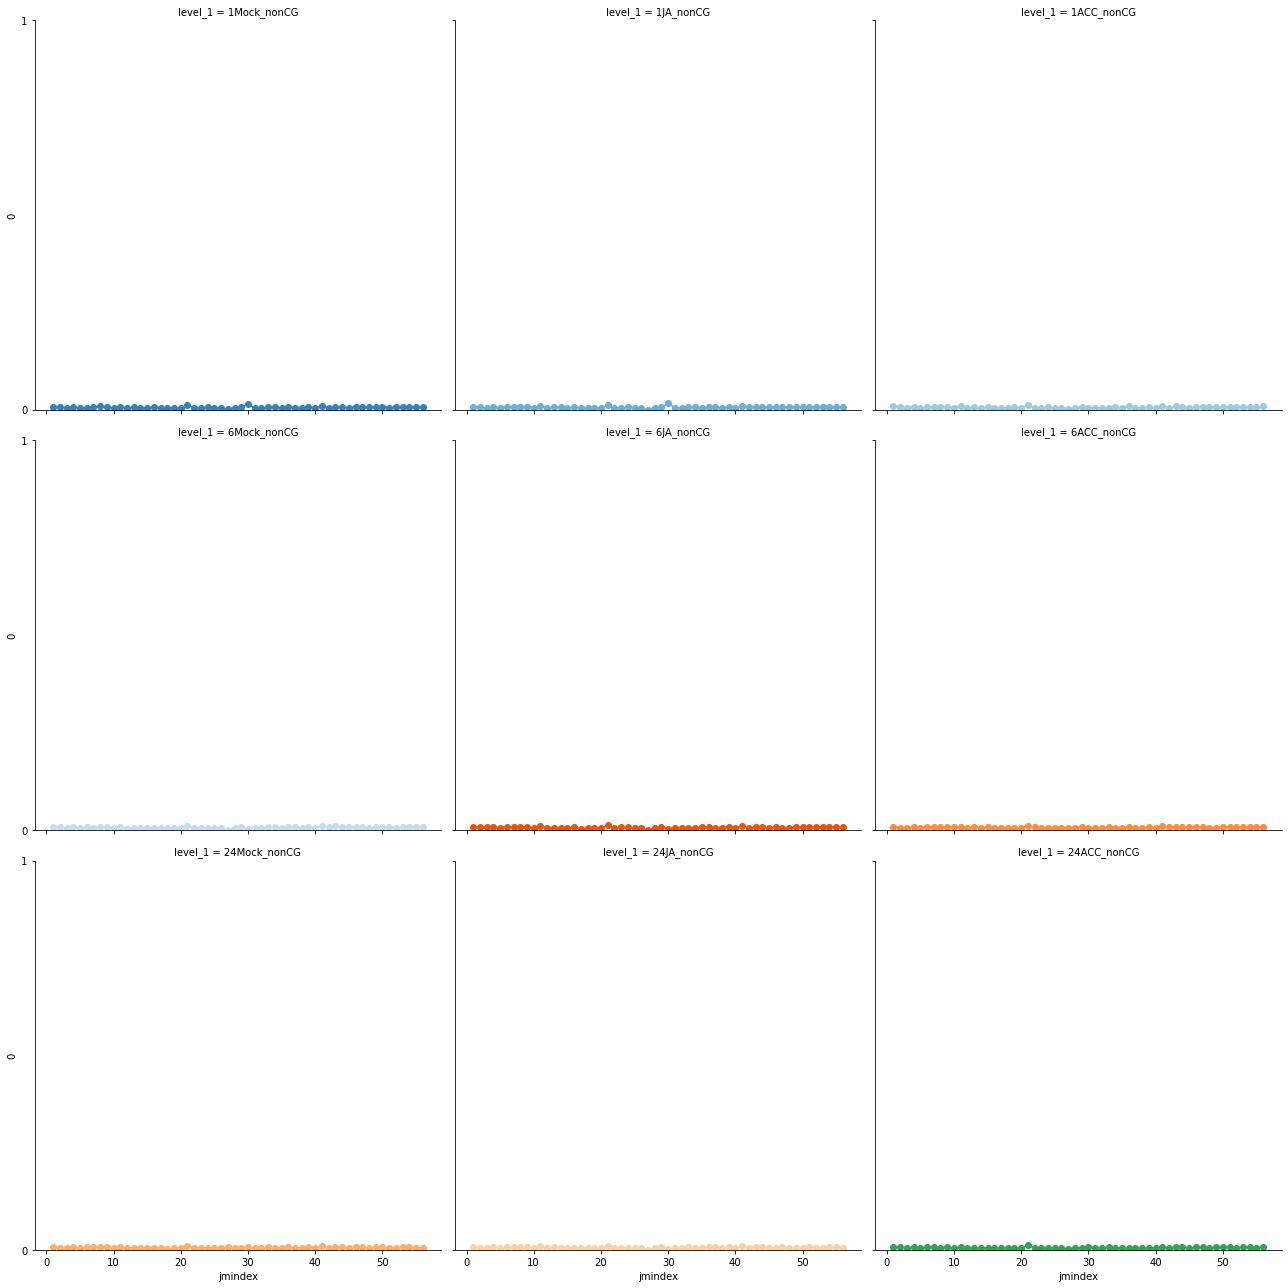

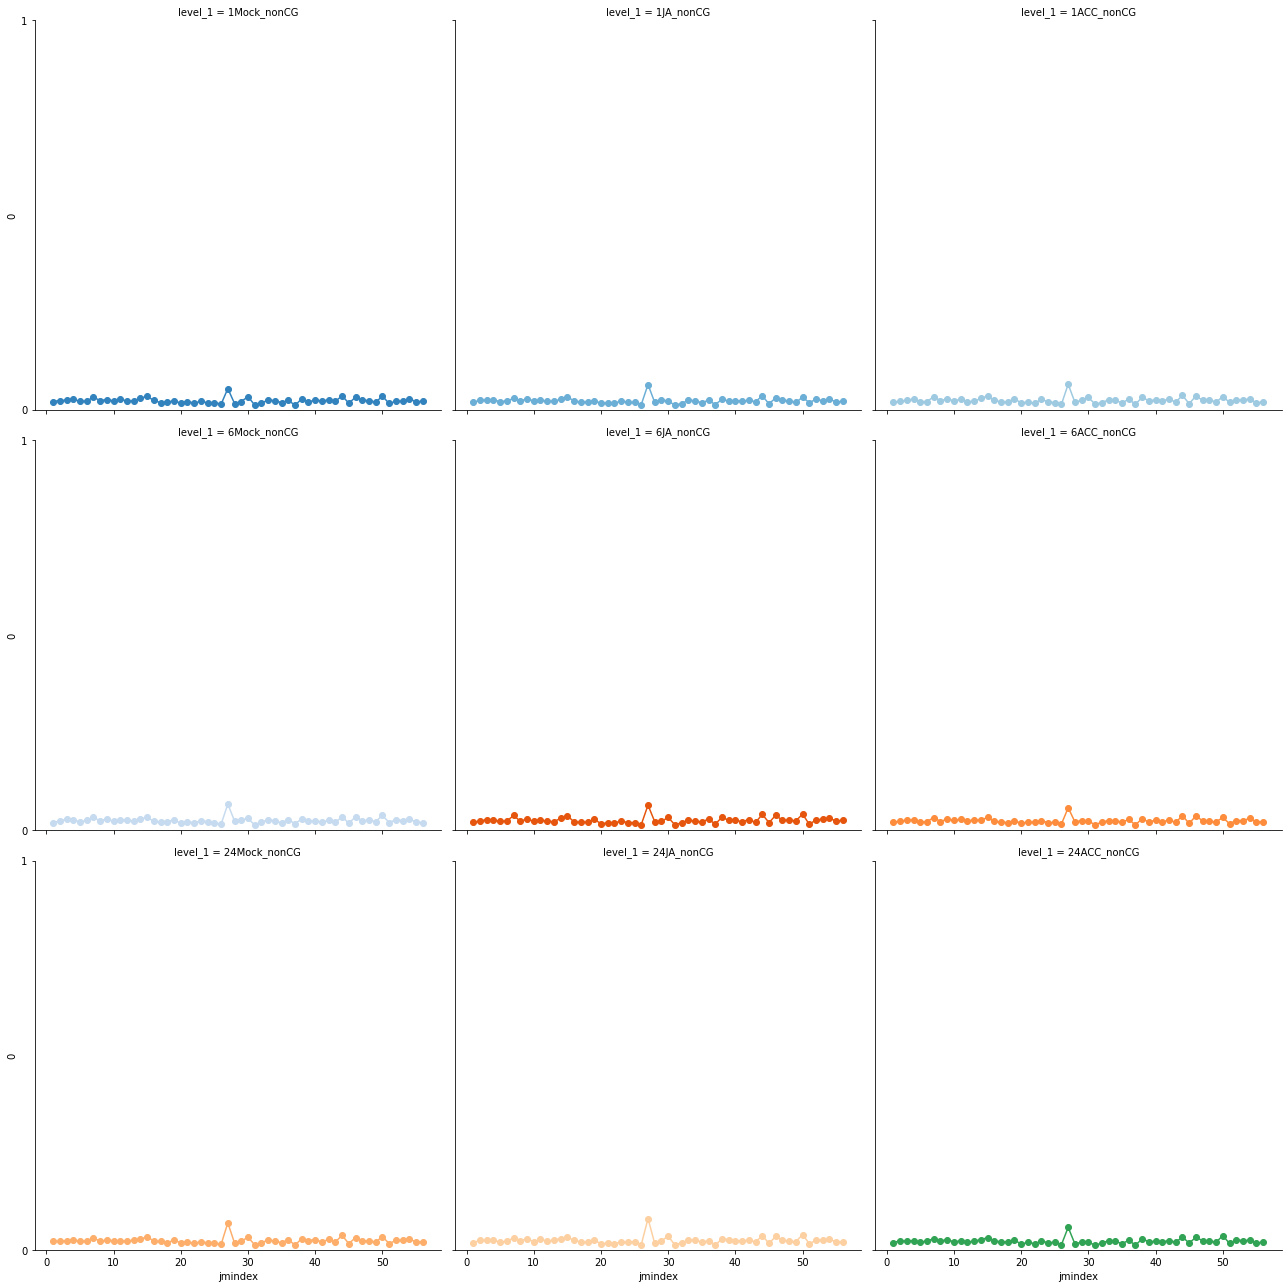

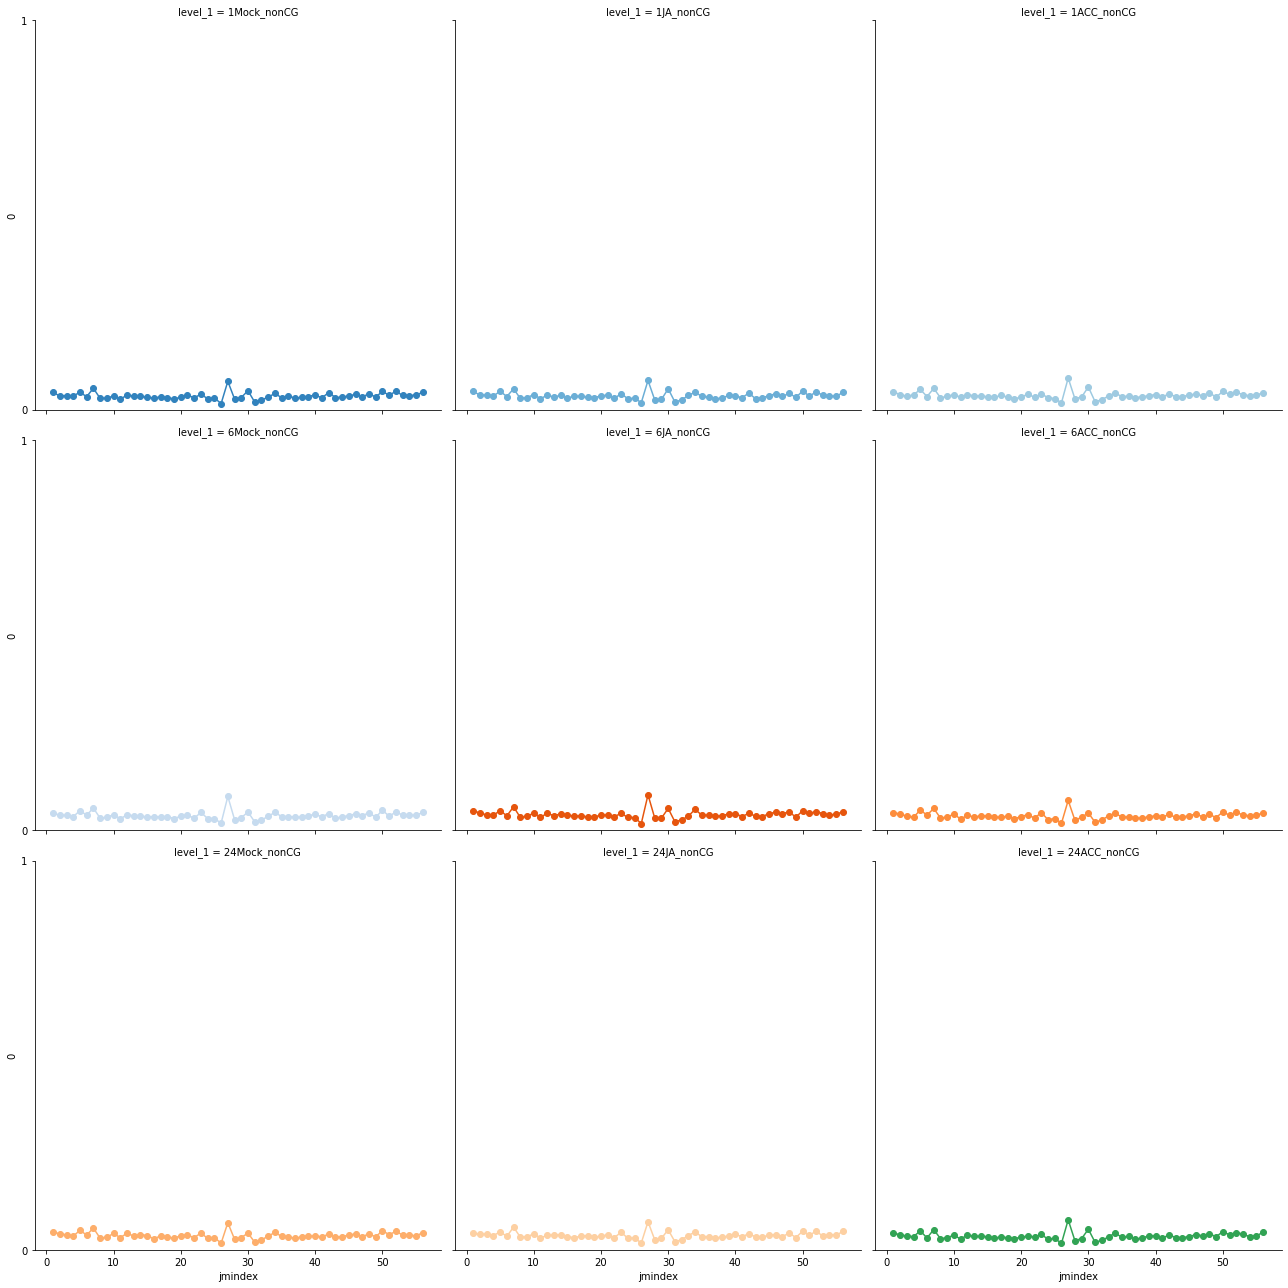

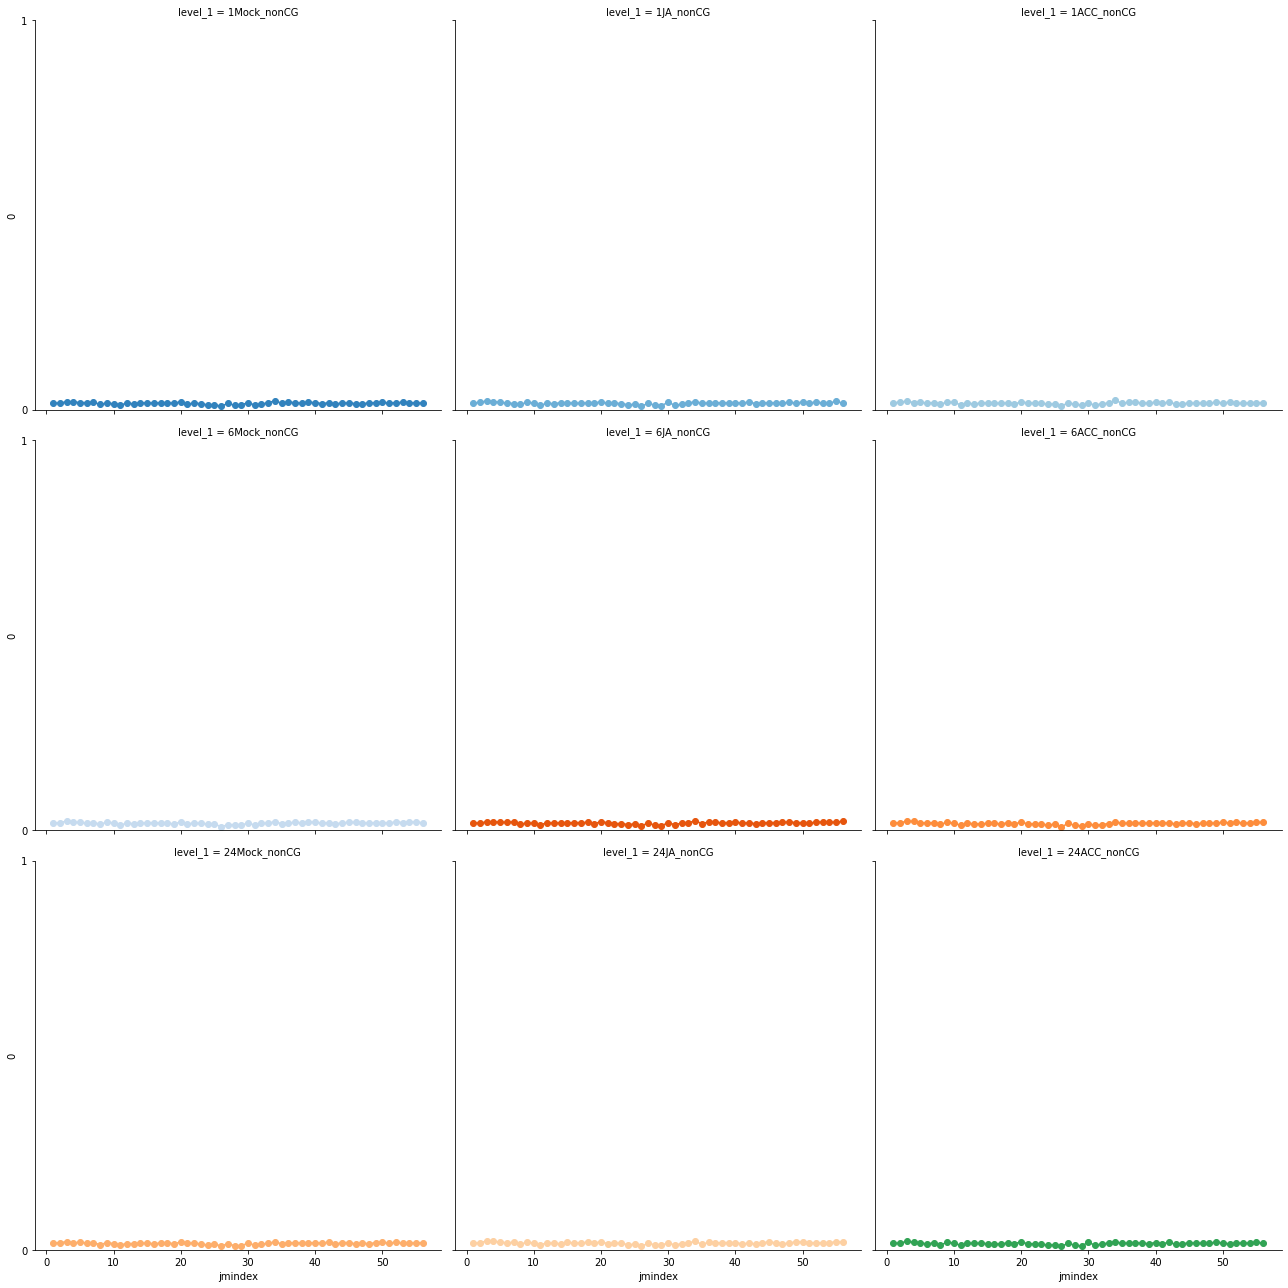

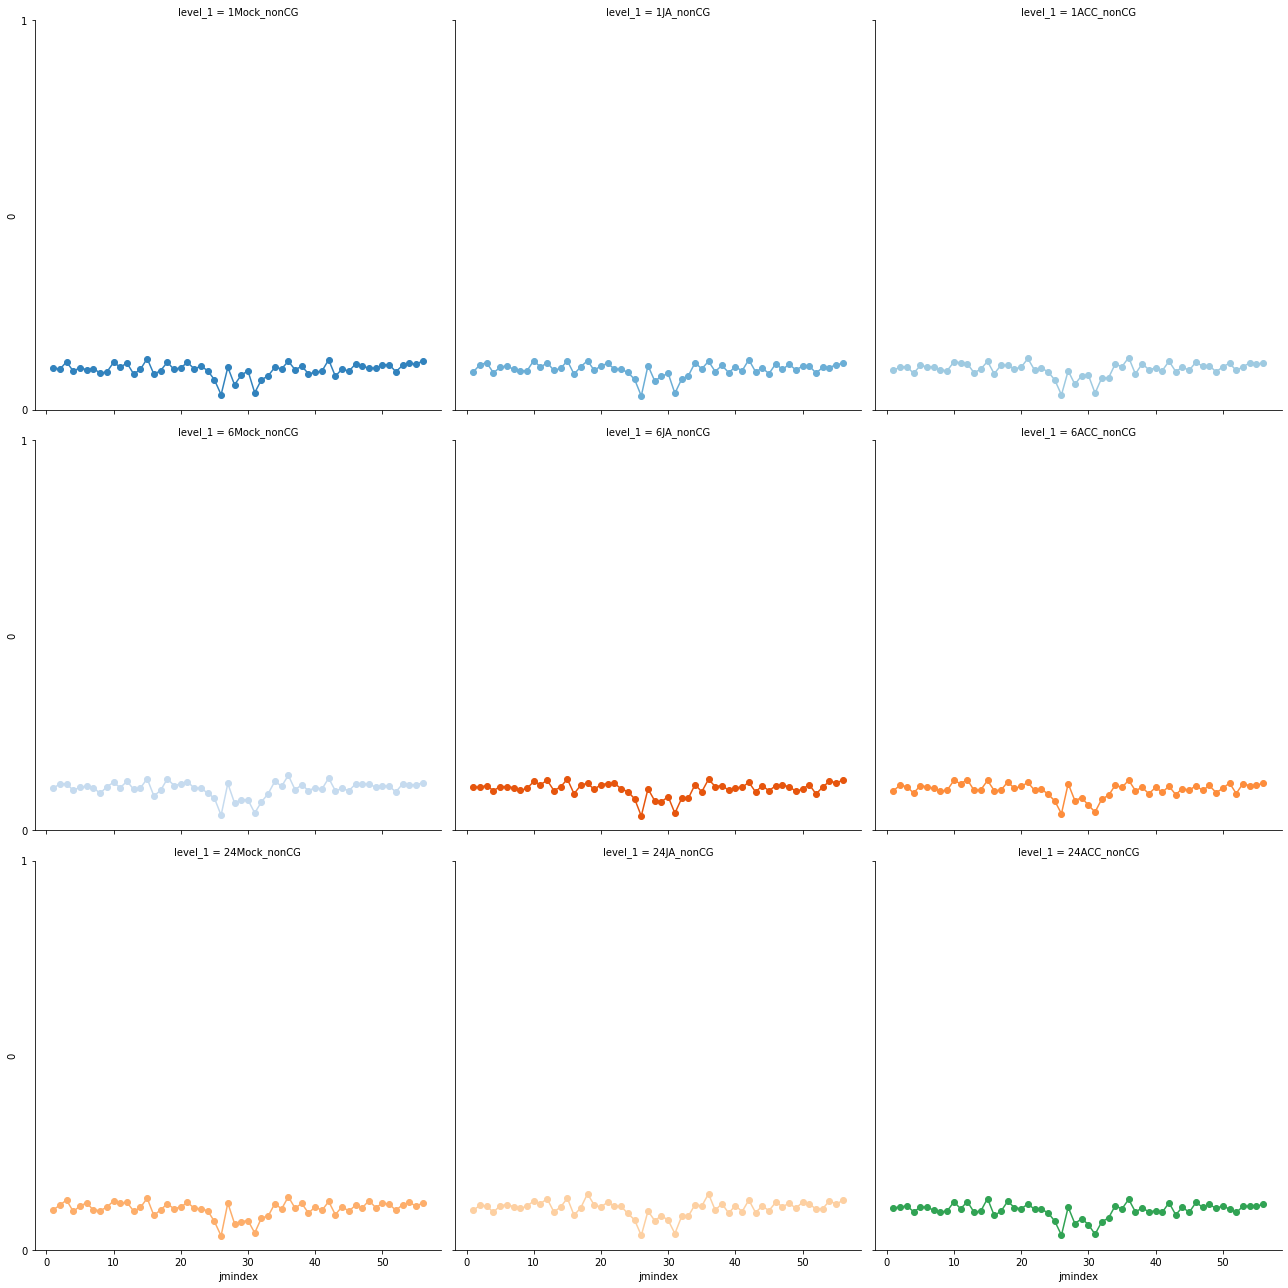

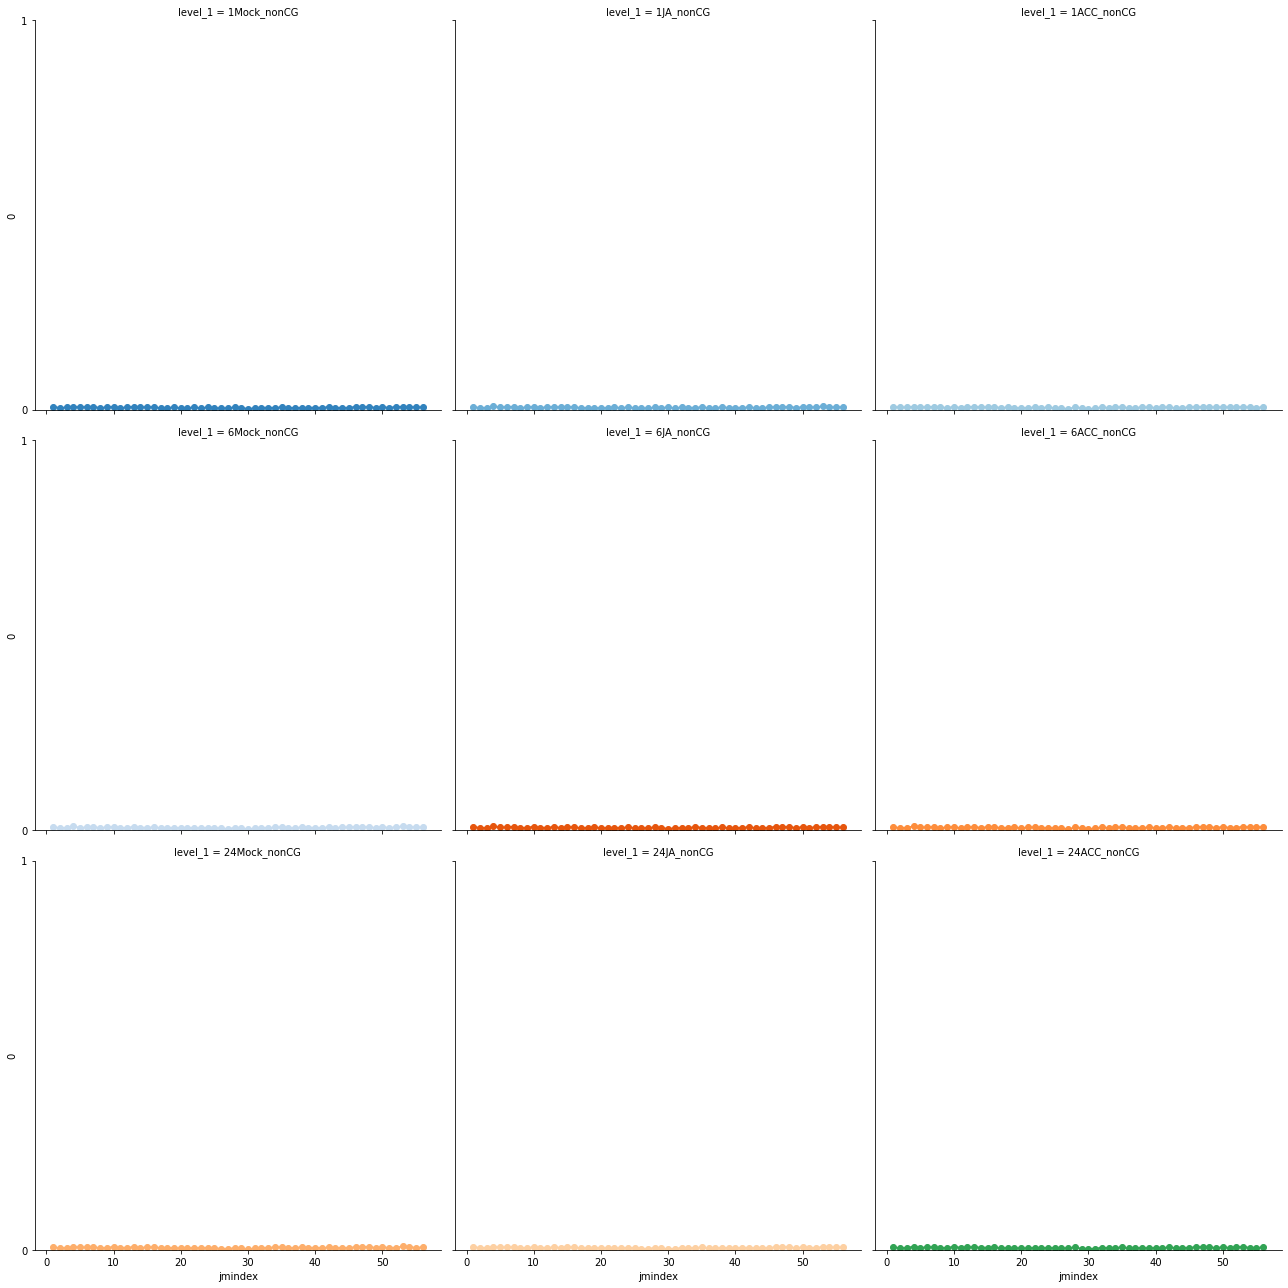

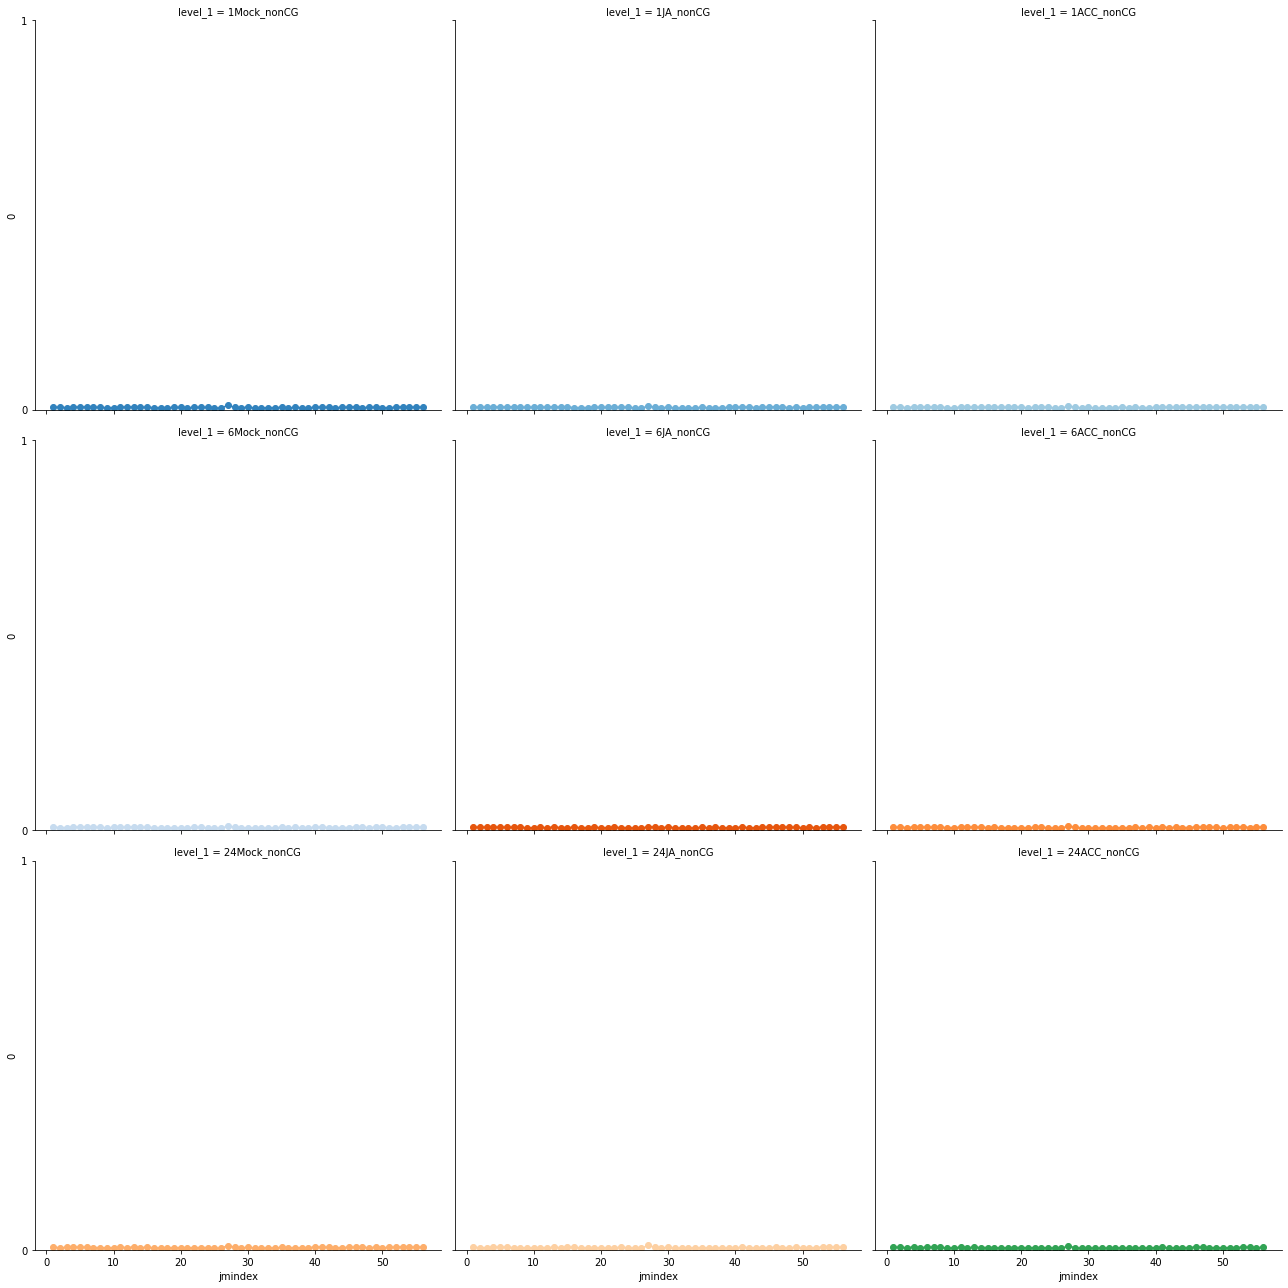

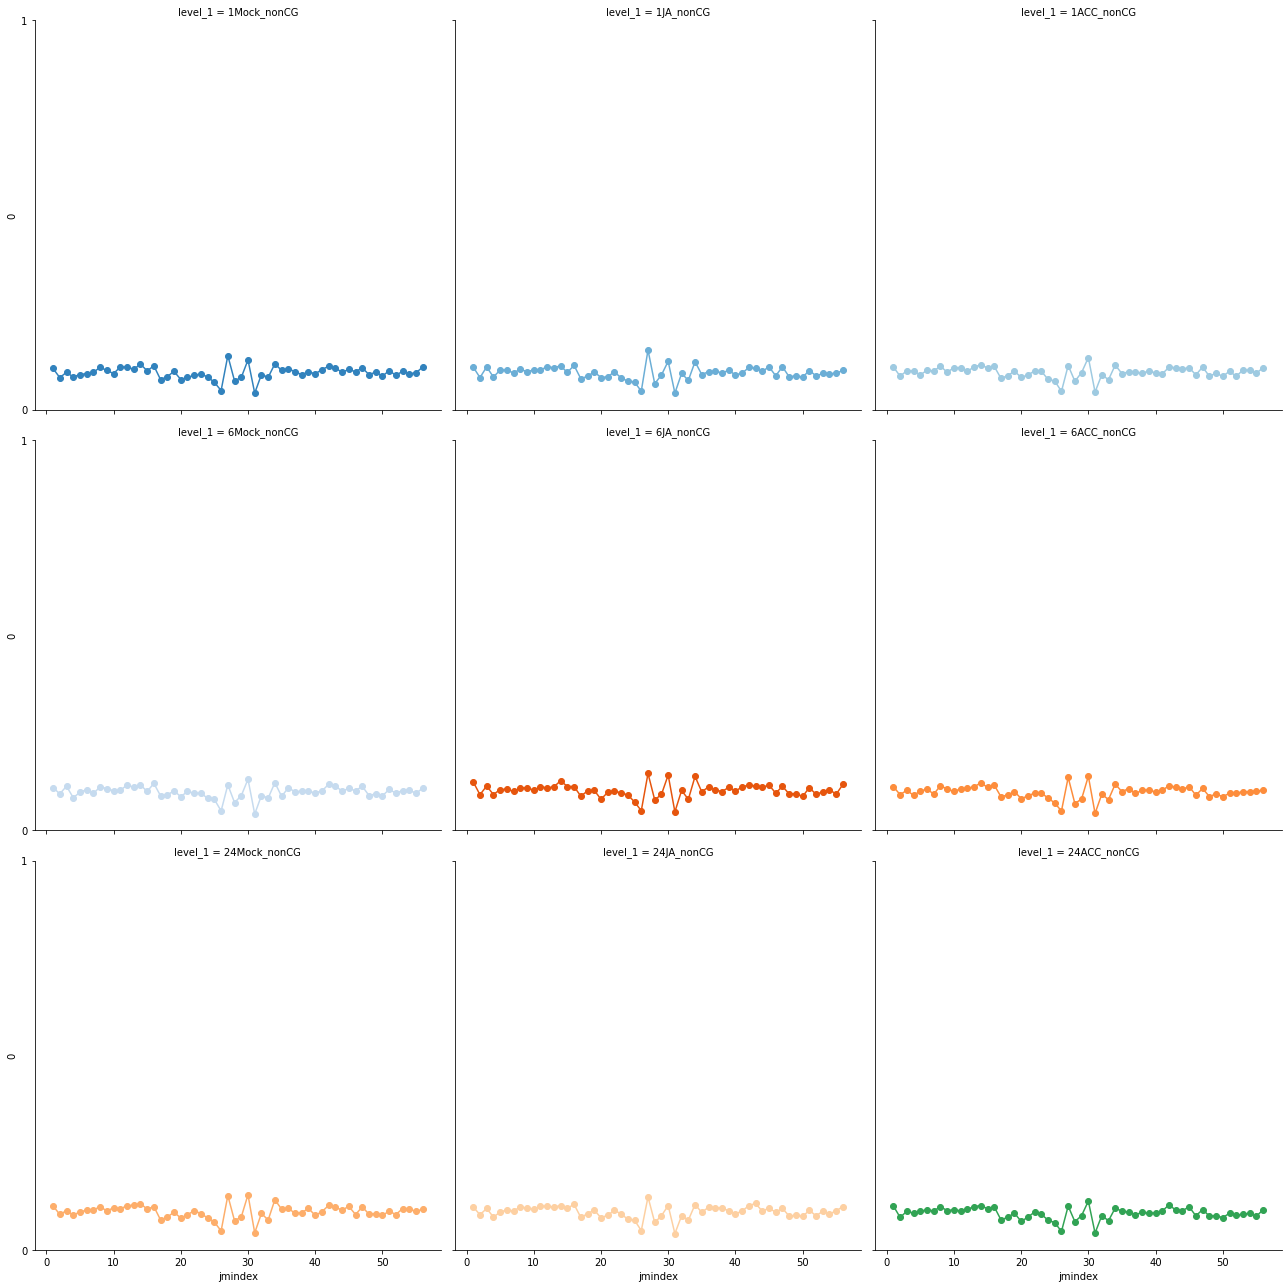

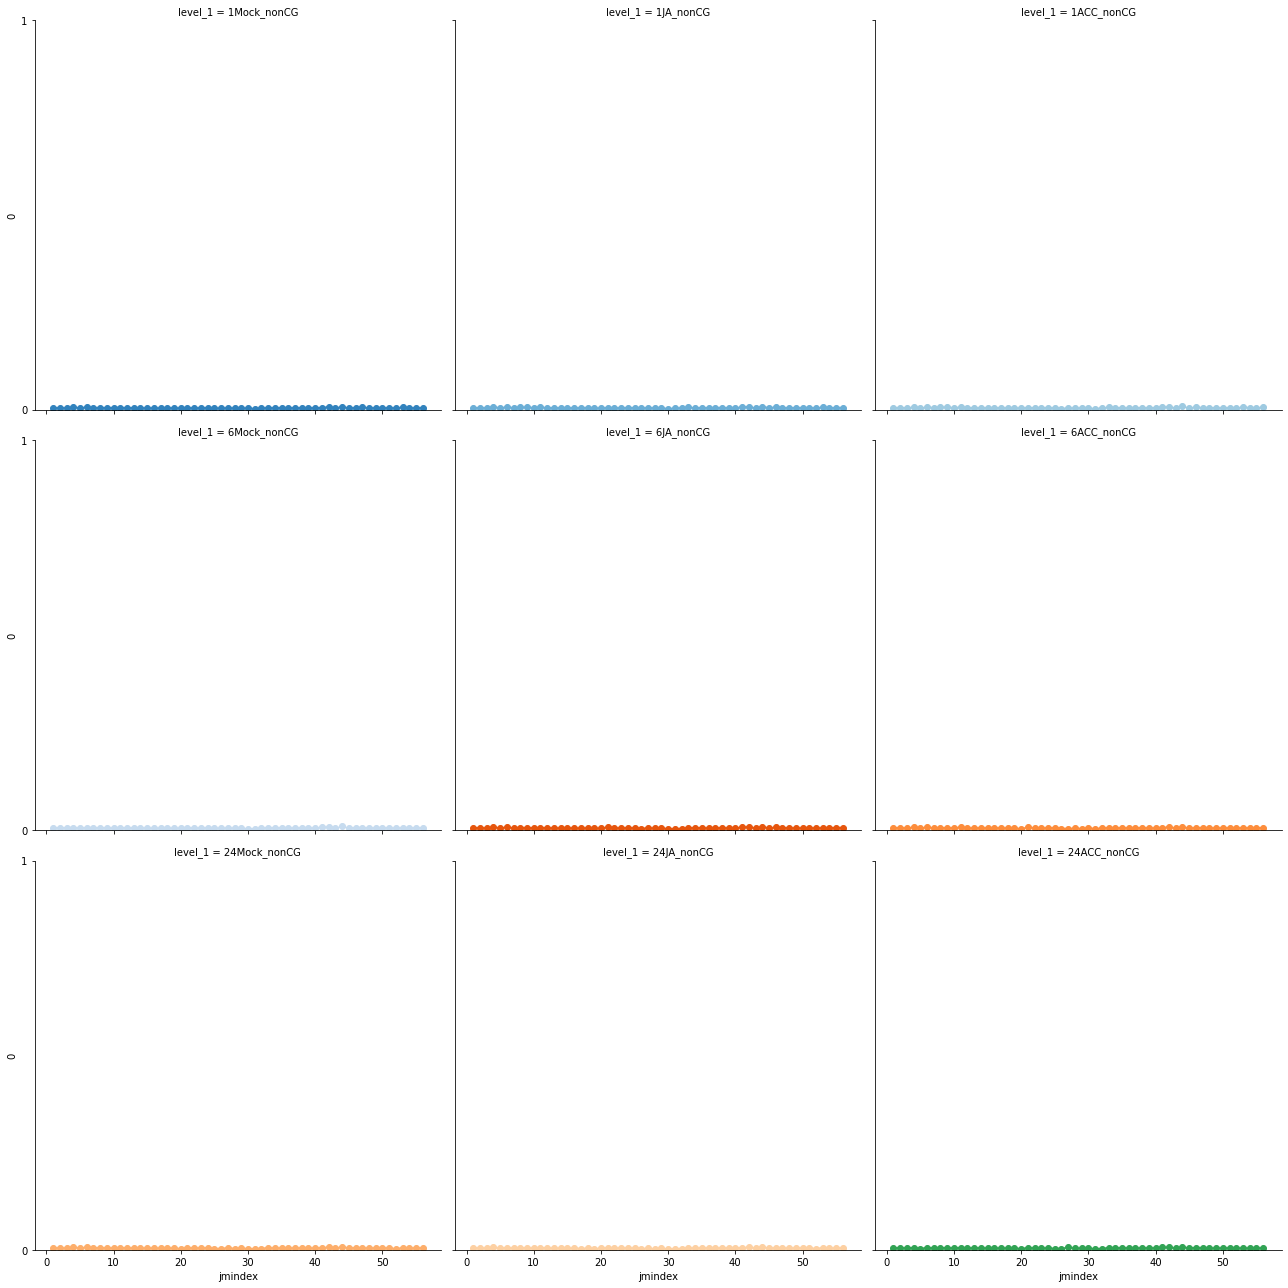

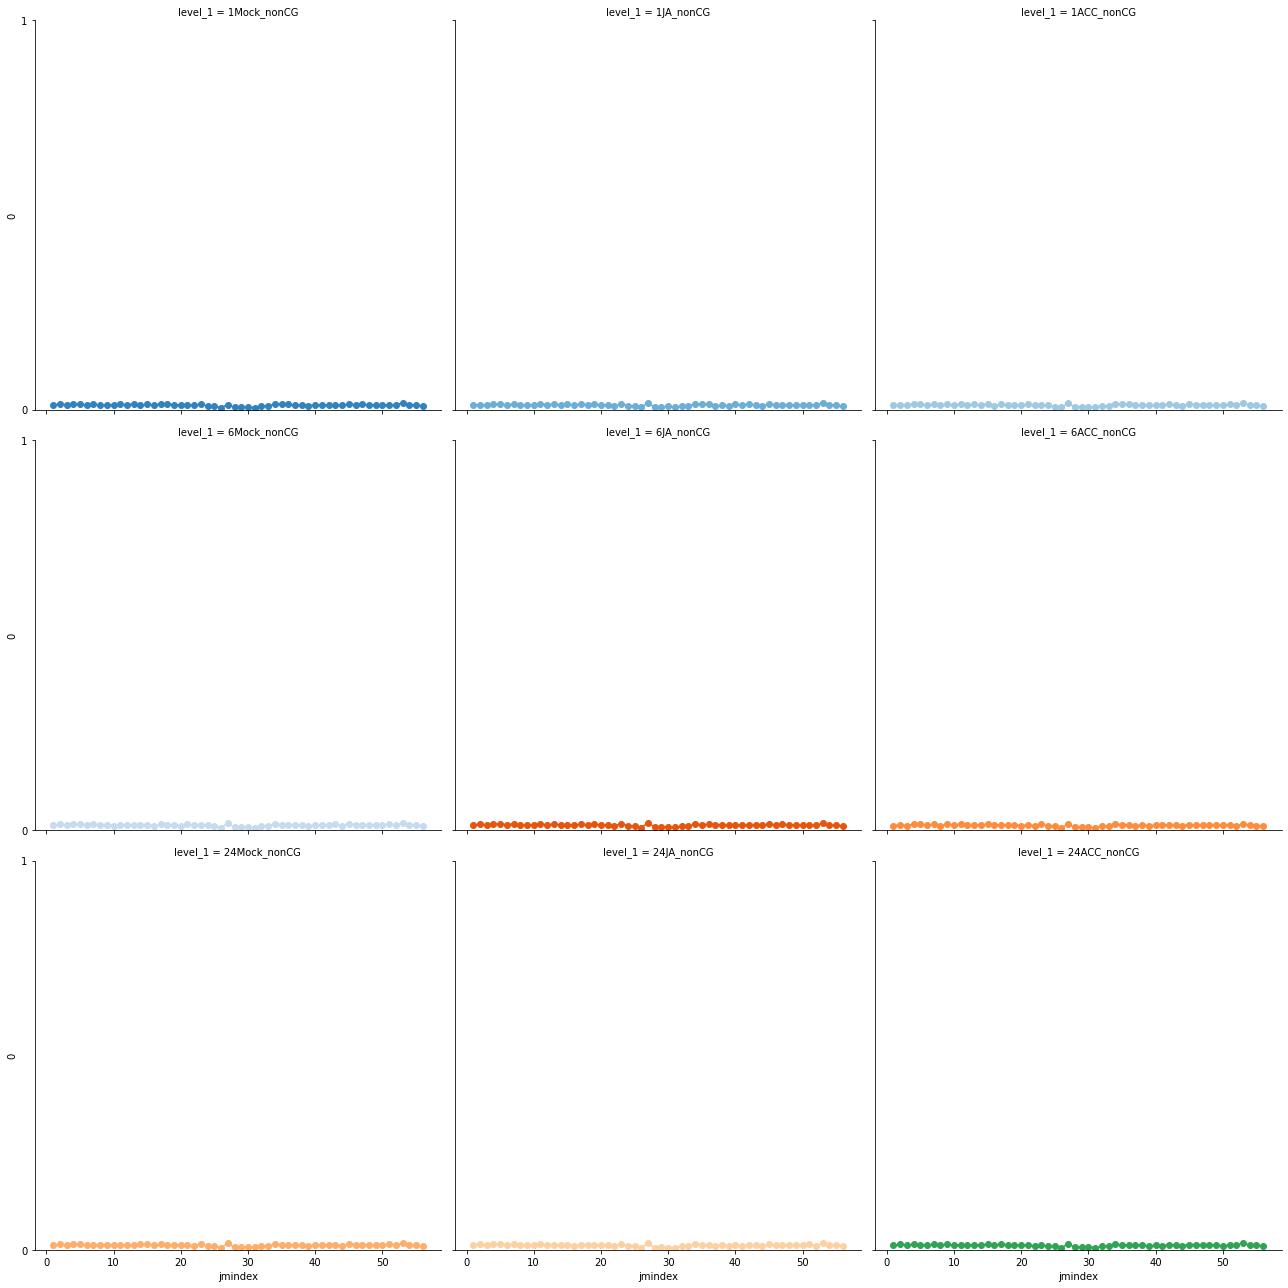

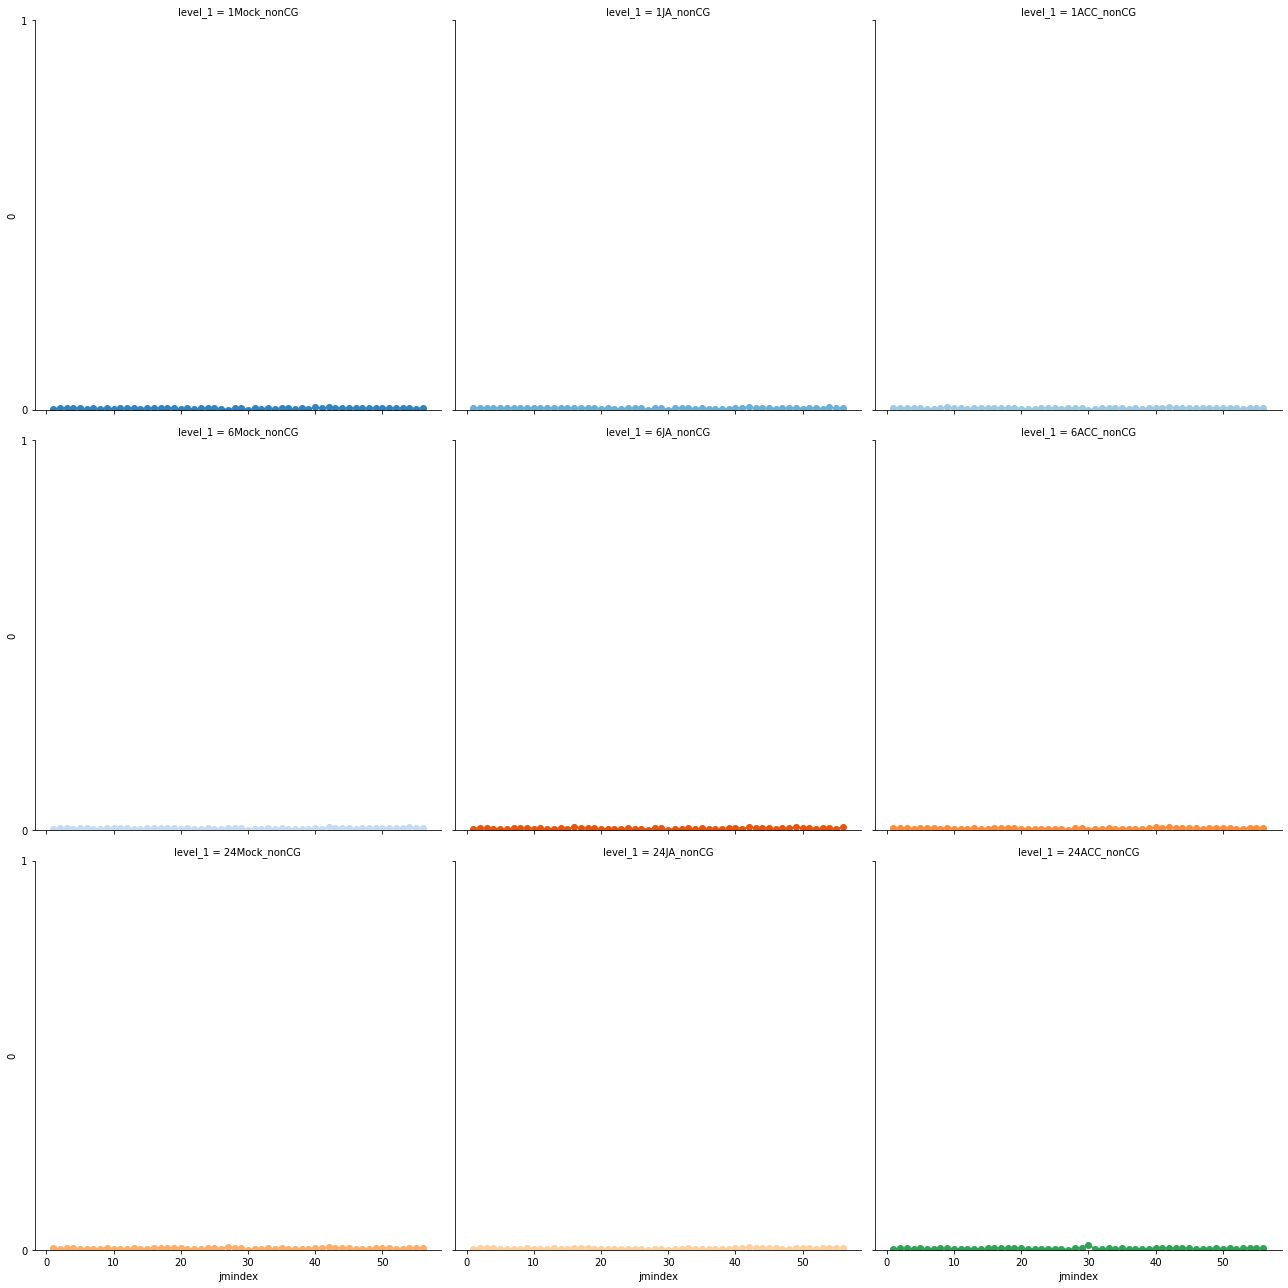

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
for clus, selection in finaldf_means.groupby('cluster'):
    print(clus)
    toplot=selection[['jmindex','1Mock_nonCG','1JA_nonCG','1ACC_nonCG','6Mock_nonCG','6JA_nonCG','6ACC_nonCG','24Mock_nonCG','24JA_nonCG','24ACC_nonCG']].groupby('jmindex').mean()
    df = toplot.stack().reset_index()
    df = toplot.stack().reset_index()
    # Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(df, col="level_1", hue="level_1", palette="tab20c",
                        col_wrap=3, height=6)



    # Draw a line plot to show the trajectory of each random walk
    grid.map(plt.plot, "jmindex", 0, marker="o")

    # Adjust the tick positions and labels
    grid.set(yticks=[0, 1], ylim=(0, 1))

    # Adjust the arrangement of the plots
    grid.fig.tight_layout(w_pad=1)
    plt.savefig(f'{folder_path_result}/{clus}_{metcontext}.pdf',
        dpi=300,
        bbox_inches="tight",
        )

In [96]:
finaldf_means = finaldf_means[['1Mock_CG','1JA_CG','1ACC_CG','6Mock_CG','6JA_CG','6ACC_CG','24Mock_CG','24JA_CG','24ACC_CG','1Mock_nonCG','1JA_nonCG','1ACC_nonCG','6Mock_nonCG','6JA_nonCG','6ACC_nonCG','24Mock_nonCG','24JA_nonCG','24ACC_nonCG']]

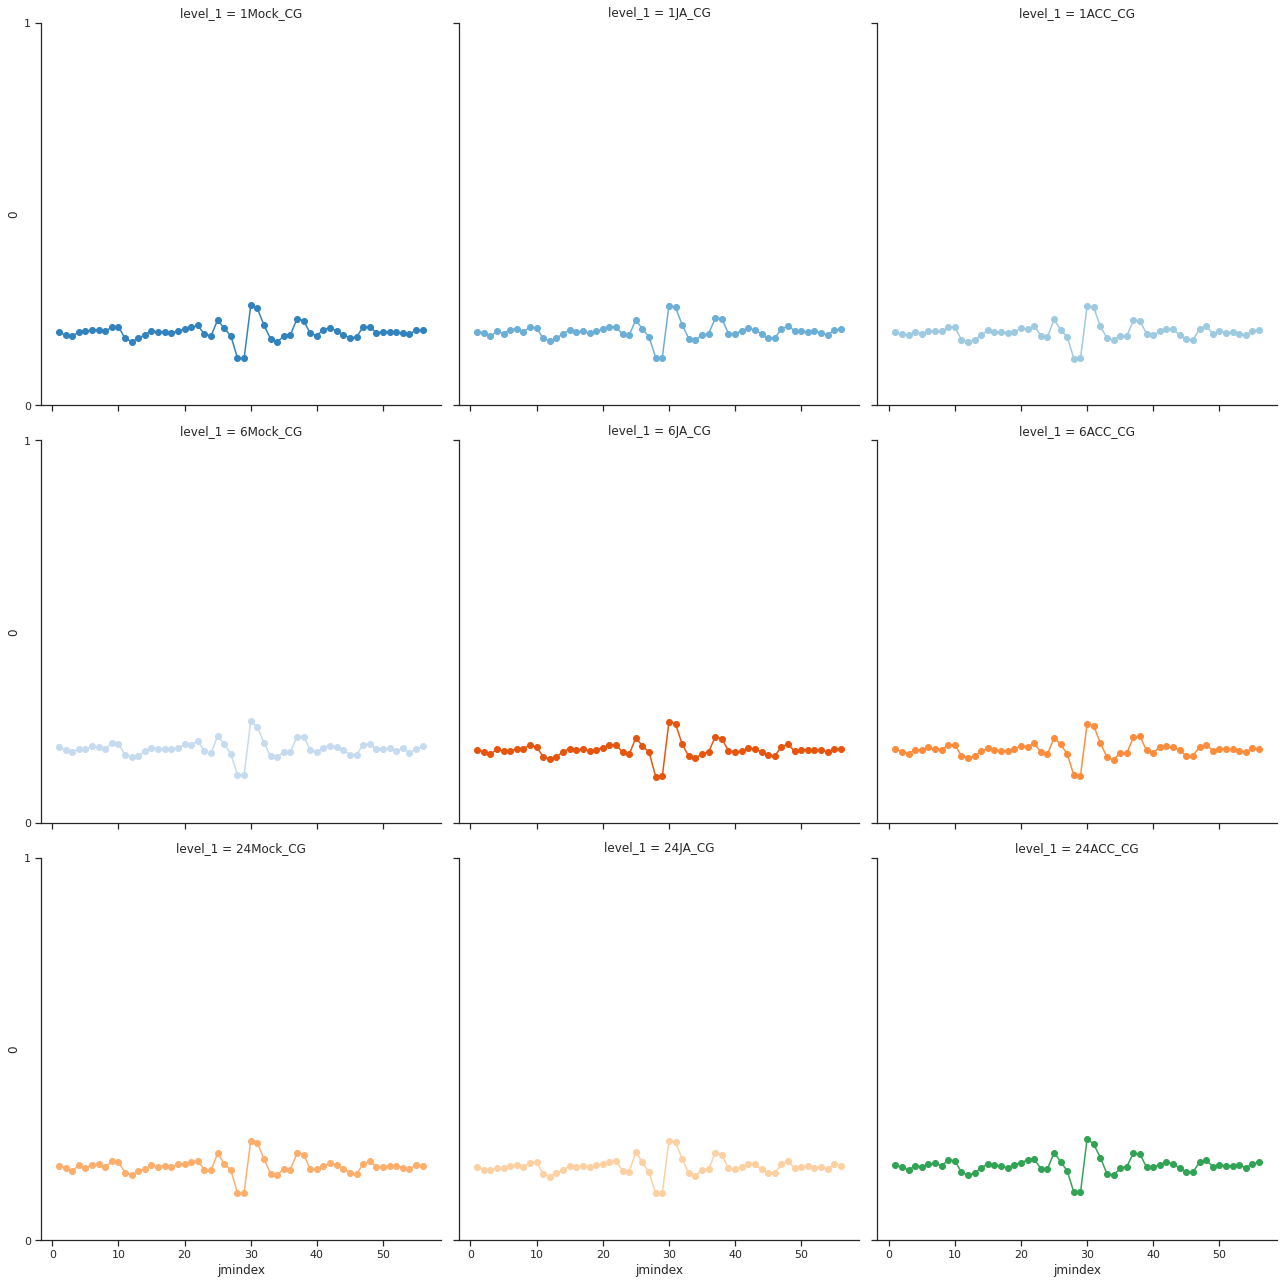

In [101]:
df = toplot.stack().reset_index()
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="level_1", hue="level_1", palette="tab20c",
                     col_wrap=3, height=6)



# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "jmindex", 0, marker="o")

# Adjust the tick positions and labels
grid.set(yticks=[0, 1], ylim=(0, 1))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

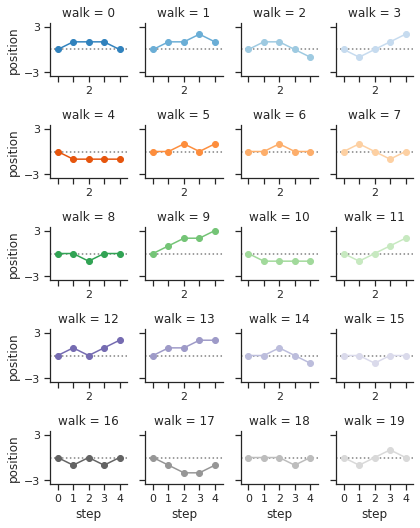

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)
df = pd.DataFrame(np.c_[pos.flat, step, walk],
                  columns=["position", "step", "walk"])

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="walk", hue="walk", palette="tab20c",
                     col_wrap=4, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "step", "position", marker="o")

# Adjust the tick positions and labels
grid.set(xticks=np.arange(5), yticks=[-3, 3],
         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

In [89]:
df

,position,step,walk
0,0,0,0
1,1,1,0
2,1,2,0
3,1,3,0
4,0,4,0
...,...,...,...
95,0,0,19
96,-1,1,19
97,0,2,19
98,1,3,19


In [79]:
finaldf_means = finaldf_means[['1Mock','1JA','1ACC','6Mock','6JA','6ACC','24Mock','24JA','24ACC']]

KeyError: "None of [Index(['1Mock', '1JA', '1ACC', '6Mock', '6JA', '6ACC', '24Mock', '24JA',\n       '24ACC'],\n      dtype='object')] are in the [columns]"

In [29]:
df_plot = df_merged[["6ACCrep3","6ACCrep1",	"6ACCrep2"]]


In [ ]:
peaksfile = '/home/joaquin/projects/methylation/data/commonData/arabidopsisThaliana/intersect/Peaks_centered_56bp.bed'

peaks = pd.read_csv(peaksfile, sep='\t', names=['chrm','start','end','boxID'])
for metcontext in ['CG','nonCG']:  
    allthedata = []
    cgdataframe = []
    noncgdataframes = []
    finaldf = None
    for experimentCondition in experimentsClasification:
        listOfDfReplicatesPercentageOfMetCs = []
        listOfDfReplicatesCualitative = []
        listOfNamesReplicates = []
        df_merged = None
        for replicatePath in experimentsClasification[experimentCondition]:
            replicateDf = None
            replicaname =  experimentCondition+replicatePath.split('/')[-4]
            replicateDf = loadFileRemoveMtsAndLowMetReport(replicatePath, metcontext)

            print(replicateDf)
            replicateDfPercentageOfMetCs = calculateValueAsPercentageOfMetCs(replicateDf,replicaname)
            print(replicateDfPercentageOfMetCs)
            listOfNamesReplicates.append(replicaname)
            listOfDfReplicatesPercentageOfMetCs.append(replicateDfPercentageOfMetCs)

        df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['chr', 'position','strand', 'boxID','context',],
                                                    how='outer'), listOfDfReplicatesPercentageOfMetCs)
        df_merged = df_merged[listOfNamesReplicates]
        df_merged = df_merged.stack().reset_index()
        df_merged = df_merged.drop(df_merged[df_merged[0] == 0].index)
        df_merged.groupby('jmindex').mean()
        break
#         print(df_merged)
# #         df_merged = df_merged.dropna()
#         df_merged[experimentCondition] = df_merged[listOfNamesReplicates].mean(axis=1)
#         print(df_merged)
#         df_merged = df_merged.drop(columns=listOfNamesReplicates)
#         allthedata.append(df_merged)
#     finaldf = reduce(lambda  left,right: pd.merge(left,right,on=['boxID'],
#                                                     how='outer'), allthedata)
#     finaldf = peaks.merge(finaldf, on='boxID', how='outer')
#     finaldf = finaldf[['chrm','start','end','boxID','1Mock','1JA','1ACC','6Mock','6JA','6ACC','24Mock','24JA','24ACC']]



#     finaldf.to_csv(f'/home/joaquin/projects/methylation/data/bisulfite_quick_and_dirty_rep1_rep2/{metcontext}_BSMet.tsv',sep='\t', index=False)
    
    
#     finaldf = finaldf.dropna()

In [49]:
replicateDf

,chr,position,strand,mets,nomets,context,boxID,6ACCrep2
0,1,1514,+,0,10,CHH,P00001,0.000000
1,1,1515,+,0,10,CHH,P00001,0.000000
2,1,1516,+,0,9,CHH,P00001,0.000000
3,1,1517,+,0,9,CHH,P00001,0.000000
4,1,1522,-,0,8,CHH,P00001,0.000000
...,...,...,...,...,...,...,...,...
1271242,5,26974868,+,0,15,CHH,P59750,0.000000
1271243,5,26974873,-,1,9,CHH,P59750,0.100000
1271244,5,26974874,+,4,11,CHH,P59750,0.266667
1271245,5,26974877,+,0,15,CHH,P59750,0.000000


In [48]:
replicateDfPercentageOfMetCs

,chr,position,strand,context,boxID,6ACCrep2
0,1,1514,+,CHH,P00001,0.000000
1,1,1515,+,CHH,P00001,0.000000
2,1,1516,+,CHH,P00001,0.000000
3,1,1517,+,CHH,P00001,0.000000
4,1,1522,-,CHH,P00001,0.000000
...,...,...,...,...,...,...
1271242,5,26974868,+,CHH,P59750,0.000000
1271243,5,26974873,-,CHH,P59750,0.100000
1271244,5,26974874,+,CHH,P59750,0.266667
1271245,5,26974877,+,CHH,P59750,0.000000


In [47]:
df_merged

,chr,position,strand,context,boxID,6ACCrep3,6ACCrep1,6ACCrep2
0,1,1514,+,CHH,P00001,0.0,0.0,0.0
1,1,1515,+,CHH,P00001,0.0,0.0,0.0
2,1,1516,+,CHH,P00001,0.0,0.0,0.0
3,1,1517,+,CHH,P00001,0.0,0.0,0.0
4,1,1522,-,CHH,P00001,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...
997155,5,26891012,+,CHH,P59698,NaN,NaN,0.0
997156,5,26891015,+,CHH,P59698,NaN,NaN,0.0
997157,5,26891019,+,CHH,P59698,NaN,NaN,0.0
997158,5,26891022,+,CHH,P59698,NaN,NaN,0.0


,chr,position,6ACC
jmindex,,,
1,2.898582,1.270772e+07,0.023032
2,2.901863,1.276829e+07,0.022230
3,2.907149,1.276114e+07,0.022863
4,2.884950,1.275124e+07,0.022601
5,2.892917,1.271976e+07,0.023478
6,2.904196,1.282941e+07,0.022282
7,2.887620,1.263748e+07,0.024131
8,2.892252,1.260739e+07,0.020377
9,2.894722,1.277293e+07,0.021752


In [30]:
df_plot = df_plot.stack().reset_index()
nocero = df_plot.drop(df_plot[df_plot[0] == 0].index)

In [45]:
nocero = df_plot.drop(df_plot[df_plot[0] == 0].index)

In [37]:
df_plot["level_1", "0"]

Index(['level_0', 'level_1', 0], dtype='object')

In [ ]:
ax = sns.lmplot(
    data=c, x=f"{tf}", y="mean_module", hue="cat",
     col="stress",
    col_wrap=4, palette=palette_c, ci=None,
    height=4, scatter_kws={"s": 20, "alpha": .5}
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'{plots_out}/cat_random_{stat_v}_{module}_{tf}.pdf',
        dpi=300,
        bbox_inches="tight",
        )

<AxesSubplot:xlabel='0', ylabel='Count'>

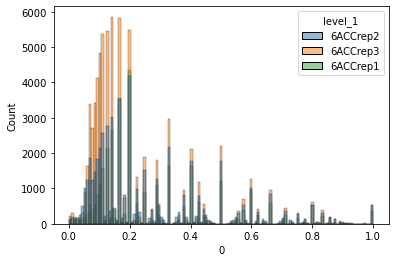

In [46]:
import seaborn as sns
sns.histplot(data=nocero,x=0 ,hue="level_1")


In [12]:
listOfDfReplicatesPercentageOfMetCs

[         chr  position strand context   boxID  6ACCrep3
 0          1      1514      +     CHH  P00001       0.0
 1          1      1515      +     CHH  P00001       0.0
 2          1      1516      +     CHH  P00001       0.0
 3          1      1517      +     CHH  P00001       0.0
 4          1      1522      -     CHH  P00001       0.0
 ...      ...       ...    ...     ...     ...       ...
 1271242    5  26974868      +     CHH  P59750       0.0
 1271243    5  26974873      -     CHH  P59750       0.0
 1271244    5  26974874      +     CHH  P59750       0.0
 1271245    5  26974877      +     CHH  P59750       0.0
 1271246    5  26974879      +     CHH  P59750       0.0
 
 [956558 rows x 6 columns],
          chr  position strand context   boxID  6ACCrep1
 0          1      1514      +     CHH  P00001  0.000000
 1          1      1515      +     CHH  P00001  0.000000
 2          1      1516      +     CHH  P00001  0.000000
 3          1      1517      +     CHH  P00001  0.000000
 

In [24]:
replicateDfPercentageOfMetCs.loc[replicateDfPercentageOfMetCs['boxID'] == '1:1538']

,boxID,1JArep2
2677,1:1538,0.0


original

In [4]:
allthedata = []
for experimentCondition in experimentsClasification:
    listOfDfReplicatesPercentageOfMetCs = []
    listOfDfReplicatesCualitative = []
    listOfNamesReplicates = []
    for replicatePath in experimentsClasification[experimentCondition]:

        replicaname =  experimentCondition+replicatePath.split('/')[-4]
        replicateDf = loadFileRemoveMtsAndLowMetReport(replicatePath)

        replicateDfPercentageOfMetCs = calculateValueAsPercentageOfMetCs(replicateDf,replicaname)

#         replicateDfCualitative = calculateValueAsCualitative(replicateDf,replicaname)
#         print(replicateDfCualitative)
        listOfNamesReplicates.append(replicaname)
        listOfDfReplicatesPercentageOfMetCs.append(replicateDfPercentageOfMetCs)
#         listOfDfReplicatesCualitative.append(replicateDfCualitative)
        
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['chr','position', 'strand','context','boxID'],
                                                how='outer'), listOfDfReplicatesPercentageOfMetCs)
    print(df_merged)
    df_merged = df_merged.dropna()
    df_merged[experimentCondition] = df_merged[listOfNamesReplicates].mean(axis=1)
    print(df_merged)
    df_merged = df_merged.drop(columns=listOfNamesReplicates)
    allthedata.append(df_merged)
finaldf = reduce(lambda  left,right: pd.merge(left,right,on=['chr','position', 'strand','context','boxID'],
                                                how='outer'), allthedata)
finaldf = finaldf.dropna()

         chr  position strand context       boxID  6ACCrep3  6ACCrep1  \
0          1      1438      +      CG      1:1538       0.0       0.0   
1          1      1439      -      CG      1:1538       0.0       NaN   
2          1      1444      -     CHH      1:1538       0.0       NaN   
3          1      1449      -     CHH      1:1538       0.0       NaN   
4          1      1450      -     CHH      1:1538       0.0       NaN   
...      ...       ...    ...     ...         ...       ...       ...   
4169007    5  26967861      -      CG  5:26967769       NaN       NaN   
4169008    5  26967865      -     CHG  5:26967769       NaN       NaN   
4169009    5  26967867      -     CHH  5:26967769       NaN       NaN   
4169010    5  26974913      +     CHH  5:26974854       NaN       NaN   
4169011    5  26974918      +     CHH  5:26974854       NaN       NaN   

         6ACCrep2  
0        0.000000  
1        0.000000  
2        0.000000  
3        0.000000  
4        0.000000  
...

         chr  position strand context       boxID  24ACCrep3  24ACCrep1  \
0          1      1438      +      CG      1:1538   0.000000   0.000000   
1          1      1439      -      CG      1:1538   0.000000   0.000000   
2          1      1444      -     CHH      1:1538   0.000000   0.000000   
3          1      1449      -     CHH      1:1538   0.000000   0.000000   
4          1      1450      -     CHH      1:1538   0.000000   0.000000   
...      ...       ...    ...     ...         ...        ...        ...   
3968949    5  26974940      -     CHH  5:26974854   0.200000   0.214286   
3968950    5  26974941      -     CHH  5:26974854   0.000000   0.000000   
3968951    5  26974943      +     CHH  5:26974854   0.166667   0.000000   
3968952    5  26974945      +     CHH  5:26974854   0.142857   0.000000   
3968953    5  26974952      +     CHH  5:26974854   0.000000   0.000000   

         24ACCrep2     24ACC  
0         0.000000  0.000000  
1         0.000000  0.000000  
2     

         chr  position strand context       boxID  1Mockrep3  1Mockrep1  \
0          1      1438      +      CG      1:1538        0.0        0.0   
1          1      1439      -      CG      1:1538        0.0        NaN   
2          1      1444      -     CHH      1:1538        0.0        NaN   
3          1      1449      -     CHH      1:1538        0.0        NaN   
4          1      1450      -     CHH      1:1538        0.0        NaN   
...      ...       ...    ...     ...         ...        ...        ...   
4149736    5  26965670      -      CG  5:26965576        NaN        NaN   
4149737    5  26965671      -     CHG  5:26965576        NaN        NaN   
4149738    5  26965672      -     CHH  5:26965576        NaN        NaN   
4149739    5  26965674      -     CHH  5:26965576        NaN        NaN   
4149740    5  26967680      +     CHH  5:26967769        NaN        NaN   

         1Mockrep2  
0              0.0  
1              0.0  
2              0.0  
3              

In [ ]:
finaldf

In [ ]:
finaldf.to_csv('/home/joaquin/projects/methylation/methylation_jose/met_site/bisulfite.tsv',sep='\t', index=False)

In [6]:
import pandas as pd 
peaksfile = '/home/joaquin/projects/methylation/data/commonData/arabidopsisThaliana/intersect/allThePossiblePeaksnine.bed'

peaks = pd.read_csv(peaksfile, sep='\t', names=['chrm','start','end','boxID'])


df = finaldf[(finaldf['context'] != 'CG')]
metadata = df.iloc[:,4:5]
values = df.iloc[:,5:]

merged = metadata.merge(values, left_index=True, right_index=True, how='inner')
meandf = merged.groupby('boxID', as_index=False).mean()
peaks = peaks.merge(meandf, on='boxID', how='outer')
peaks = peaks[['chrm','start','end','boxID','1Mock','1JA','1ACC','6Mock','6JA','6ACC','24Mock','24JA','24ACC']]



# peaks.to_csv('/home/joaquin/projects/methylation/data/bisulfite_quick_and_dirty_rep1_rep2/CG_BSMet_remove_nan_local_mode.tsv',sep='\t', index=False)

# peaks.to_csv('CHG_BSMet_mean.tsv',sep='\t', index=False)

peaks.to_csv('/home/joaquin/projects/methylation/data/bisulfite_quick_and_dirty_rep1_rep2/non-CG_BSMet_remove_nan_local_mode.tsv.tsv',sep='\t', index=False)
# meandf['chr'], meandf['start'], meandf['end'] =  zip(*meandf['boxID'].map(lambda x: getpositions(x)))

In [ ]:
df

In [ ]:
metadata

In [ ]:
values

In [ ]:
merged

In [ ]:
meandf

In [ ]:
peaks